# Inter-Maimi - PROD Retention Score
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* June 20, 2022

## Hypothesis


## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [3]:
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMLS].[ds].[getRetentionScoringModelData_staging2] """
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(6909, 15)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6909 entries, 0 to 6908
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  6909 non-null   int64  
 1   year                 6909 non-null   int64  
 2   productGrouping      6909 non-null   object 
 3   totalSpent           6909 non-null   float64
 4   recentDate           6909 non-null   object 
 5   attendancePercent    6909 non-null   float64
 6   renewedBeforeDays    6909 non-null   int64  
 7   source_tenure        6909 non-null   int64  
 8   tenure               6909 non-null   int64  
 9   distToVenue          6670 non-null   float64
 10  recency              6909 non-null   int64  
 11  missed_games_1       6909 non-null   int64  
 12  missed_games_2       6909 non-null   int64  
 13  missed_games_over_2  6909 non-null   int64  
 14  isNextYear_Buyer     6909 non-null   int64  
dtypes: float64(3), int64(10), object(2)
me

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
            "dimCustomerMasterId",
            "year",
            "productGrouping", 
            "totalSpent", 
            "recentDate",
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2",
            "isNextYear_Buyer"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (3596, 15)
Unseen Data For Predictions: (634, 15)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "totalSpent", 
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2"
    ]
);

In [7]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [8]:
model_matrix = compare_models(
    fold=10,
    include=["lr","xgboost","lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.6293,0.6776,0.6547,0.6155,0.6341,0.2591,0.2600,0.4480
lr,Logistic Regression,0.6280,0.6806,0.7093,0.6040,0.6522,0.2578,0.2619,0.3800
lightgbm,Light Gradient Boosting Machine,0.6273,0.6814,0.6713,0.6104,0.6391,0.2556,0.2571,0.6730
rf,Random Forest Classifier,0.6204,0.6827,0.6667,0.6034,0.6330,0.2419,0.2437,0.1450


In [9]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6013,0.6572,0.6093,0.5935,0.6013,0.2028,0.2028
1,0.6438,0.7118,0.6755,0.6296,0.6518,0.2881,0.2889
2,0.6275,0.6904,0.6424,0.6178,0.6299,0.2552,0.2554
3,0.6275,0.6512,0.6667,0.6098,0.6369,0.2560,0.2570
4,0.6046,0.6626,0.6267,0.5912,0.6084,0.2098,0.2101
5,0.6667,0.6934,0.7333,0.6395,0.6832,0.3350,0.3385
6,0.6197,0.6718,0.6000,0.6164,0.6081,0.2388,0.2389
7,0.6393,0.7080,0.7000,0.6176,0.6562,0.2800,0.2825
8,0.6328,0.6695,0.6667,0.6173,0.6410,0.2663,0.2671
9,0.6295,0.6601,0.6267,0.6225,0.6246,0.2589,0.2589


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To

### Let's load in our 2021 season data and get retention scores using the model:

In [10]:
df_inference = df.loc[df["year"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference.shape

(2679, 15)

In [11]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,dimCustomerMasterId,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,source_tenure,tenure,distToVenue,recency,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer,Label,Score_0,Score_1
0,42,2022,Flex Plan,312.0,1970-01-01,0.00,10,730,150,38.20,0,0,0,0,0,0,0.9987,0.0013
2,96,2022,Full Season,12257.0,2022-05-28,0.57,162,730,949,48.37,0,0,0,1,0,1,0.2675,0.7325
5,107,2022,Full Season,875.5,2022-05-14,0.43,159,730,950,57.52,1,2,1,0,0,0,0.6678,0.3322
7,138,2022,Full Season,850.0,2022-05-28,0.86,33,1095,1095,17.84,0,2,0,0,0,0,0.6546,0.3454
9,152,2022,Full Season,595.0,2022-05-28,1.00,101,730,1073,52.21,0,1,0,0,0,0,0.7739,0.2261


In [12]:
new_predictions["Label"].value_counts()

0    1934
1     745
Name: Label, dtype: int64

In [13]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    1139
(0.2, 0.4]        559
(0.4, 0.6]        441
(0.6, 0.8]        344
(0.8, 1.0]        196
Name: Score_1, dtype: int64

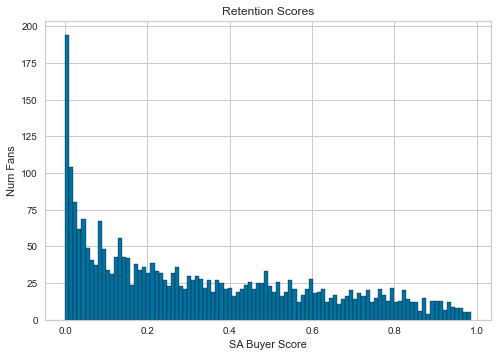

In [14]:
plt.hist(new_predictions["Score_1"], bins=100, edgecolor='black')
plt.title("Retention Scores")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.show()

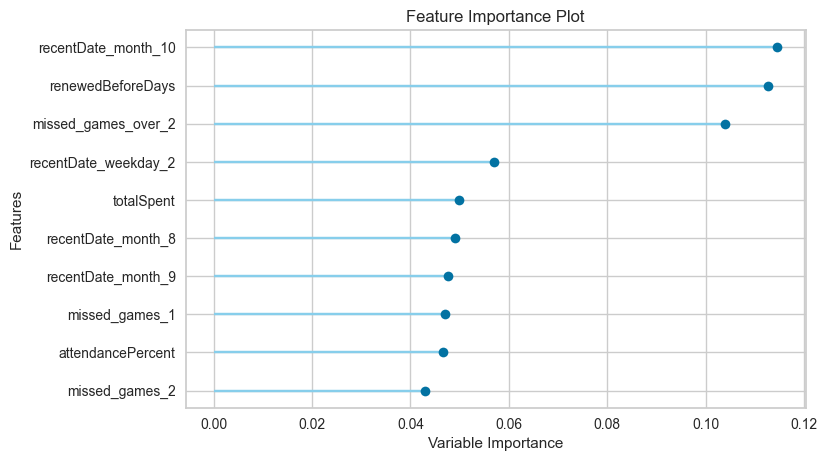

In [15]:
plot_model(best_model, plot='feature')

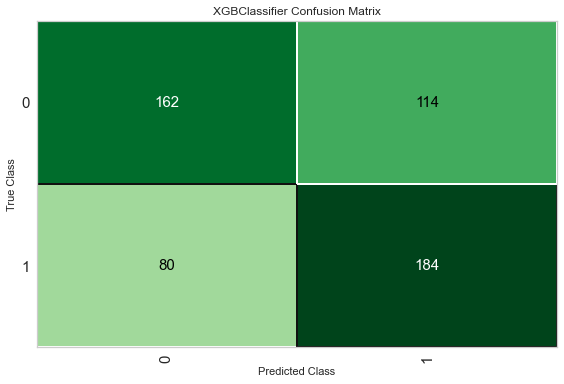

In [16]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above